In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon
import pickle 
import cv2 as cv

from src.vican.vican.cam import estimate_pose_mp, estimate_pose_charuco_worker
from src.vican.vican.bipgo import bipartite_se3sync, object_bipartite_se3sync
from src.vican.vican.plot import plot2D, plot_cams_3D
from src.vican.vican.dataset import Dataset

# Edit path to the folder containing the renders
DATASET_PATH = "./dataset/optitrack_videos/output_frames"
#DATASET_PATH= "./dataset/big_dataset"

# Edit path to the folder containing the cube calibration images.
#OBJ_DATASET_PATH = "./dataset/realsense_charuco_object"
OBJ_DATASET_PATH = "./dataset/big_dataset_object"

LOAD = True

dataset     = Dataset(root=DATASET_PATH)
obj_dataset = Dataset(root=OBJ_DATASET_PATH)

# TODO: why???
for k, v in dataset.cams.items():
    dataset.cams[k].distortion = np.zeros((1,5,))

for k, v in obj_dataset.cams.items():
    obj_dataset.cams[k].distortion = np.zeros((1,5,))
    
    
obj_dataset.cams["0"].distortion.shape

(1, 5)

# Use below to rename object calib files (if needed) !!

In [2]:
import os
from PIL import Image
import os

# fix object image names

folders = os.listdir(OBJ_DATASET_PATH)
for folder in folders:
    if os.path.isdir(os.path.join(OBJ_DATASET_PATH, folder)):
        file = os.listdir(os.path.join(OBJ_DATASET_PATH, folder))[0].split('.')[0]
        if file != folder:
            os.rename(os.path.join(OBJ_DATASET_PATH, folder, file + ".png"), os.path.join(OBJ_DATASET_PATH, folder, folder + ".jpg"))
        #print(folder, file)
        
# Define the function to convert PNG to JPG
for root, dirs, files in os.walk(DATASET_PATH):
    for file in files:
        if file.endswith(".png"):
            png_path = os.path.join(root, file)
            jpg_path = os.path.splitext(png_path)[0] + ".jpg"
            os.rename(png_path, jpg_path)



# CharucoBoards Definitions

In [3]:
from src.vican.vican.cam import estimate_pose_charuco_worker

charuco_dict = dict()

board_idx = 0
for i in [0, 25, 49]:
    charuco_dict[str(board_idx)] = dict()
    charuco_dict[str(board_idx)]["sizeX"] = 8
    charuco_dict[str(board_idx)]["sizeY"] = 6
    charuco_dict[str(board_idx)]["squareLength"] = 0.029
    charuco_dict[str(board_idx)]["markerLength"] = 0.021
    charuco_dict[str(board_idx)]["dictionary"] = cv.aruco.DICT_4X4_100
    charuco_dict[str(board_idx)]["ids"] = np.arange(24)+i
    board_idx += 1

charuco_dict["detector"] = estimate_pose_charuco_worker
charuco_dict["num_boards"] = board_idx -1

# Arucos Definition

In [4]:
from src.vican.vican.cam import estimate_pose_aruco_worker

aruco_obj = dict()
aruco_obj["dictionary"] = 'DICT_ARUCO_ORIGINAL'
aruco_obj["marker_size"] = 0.087
aruco_obj["marker_ids"] = ['10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8', '9']
aruco_obj["corner_refine"] = 'CORNER_REFINE_SUBPIX'
aruco_obj["detector"] = estimate_pose_aruco_worker

# Verify OpenCV detection

[[-2.08056438]
 [-1.77383814]
 [-0.93199565]] 10
[[-2.06589901]
 [-1.68344903]
 [-0.99412357]] 9
[[-2.07392333]
 [-1.78121759]
 [-0.90134973]] 8
[[-1.58819777]
 [-0.76449495]
 [-0.19050271]] 5
[[ 1.89846874]
 [ 1.3709306 ]
 [-0.65366803]] 6
[[ 1.89235606]
 [ 1.37986762]
 [-0.72567434]] 7


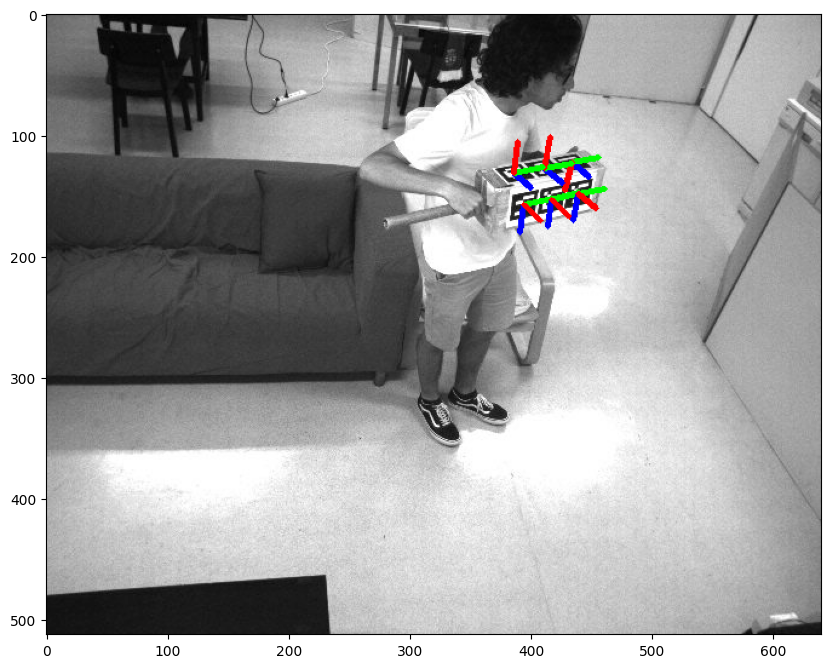

In [11]:
import cv2 as cv
from src.vican.vican.plot import detect_and_draw_charuco, detect_and_draw_aruco

%matplotlib inline

plt.figure(figsize=(10,10))

im = detect_and_draw_aruco(dataset.im_data["filename"][205],
                            'DICT_ARUCO_ORIGINAL',
                            dataset.cams["0"],
                            0,
                            0)

plt.imshow(im)


# Calibrate object

In [21]:
if not LOAD:
    # This will compute camera-marker edges via PnP, in parallel
    aux = estimate_pose_mp(cams=obj_dataset.im_data['cam'],
                           im_filenames=obj_dataset.im_data['filename'],
                           target_dict = aruco_obj,
                           flags='SOLVEPNP_IPPE_SQUARE',
                           brightness=0,
                           contrast=0)
    
    pickle.dump(aux, open(os.path.join(OBJ_DATASET_PATH, 'cube_calib_pose.pkl'), 'wb'))
else:
    aux = pickle.load(open(os.path.join(OBJ_DATASET_PATH, 'cube_calib_pose.pkl'), 'rb'))
    print("Loaded")

Loaded


In [22]:
# Optimization - see extended paper
#print( aux.keys() )
obj_pose_est = object_bipartite_se3sync(aux,
                                        noise_model_r=lambda edge : 0.01 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**1,
                                        noise_model_t=lambda edge : 0.01 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**1,
                                        edge_filter=lambda edge : edge['reprojected_err'] < 10.0,
                                        maxiter=4,
                                        lsqr_solver="conjugate_gradient",
                                        dtype=np.float64)


Received graph with 2010 nodes 9829 edges
Applying constraints (0.716s).
Bipartite graph: 12 cameras, 1998 timesteps, 9829 edges.
Building 12x1998 adjacency and 36x5994 SO(3) sparse matrices (0.103s).
Building power graph (0.015s).


Optimizing:   0%|                                                   | 0/4 [00:00<?, ?it/s]

Building sparse 29487x6030 incidence matrix (1.609s).
Solving sparse linear system (0.032s).
Done!


# object edges errors

0.3737317
0.30462155


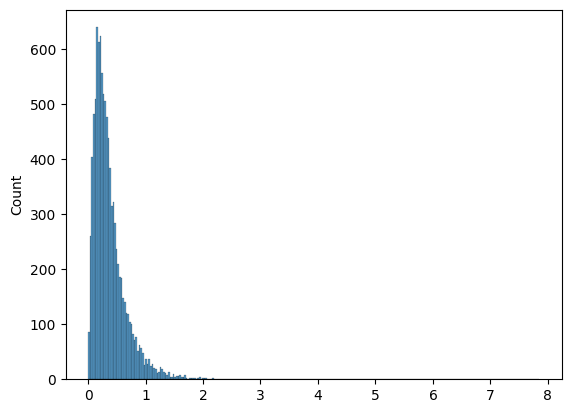

In [5]:
# plot histogram of reprojected errors
sns.histplot([edge['reprojected_err'] for edge in aux.values()])

# print the mean and std of the reprojected errors
print(np.mean([edge['reprojected_err'] for edge in aux.values()]))
print(np.std([edge['reprojected_err'] for edge in aux.values()]))

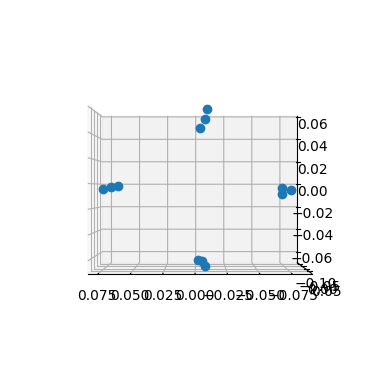

In [33]:
%matplotlib inline

xyz = np.stack([pose.t() for pose in obj_pose_est.values()], axis=0)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=0, azim=90, roll=0)

ax.plot(xyz[:,0], xyz[:,1], xyz[:,2], 'o')
ax.set_aspect('equal')
plt.show()

# Detect markers & estimate camera-marker poses

In [7]:
if not LOAD:
    # This will compute camera-marker edges via PnP, in parallel
    cam_marker_edges = estimate_pose_mp(cams=dataset.im_data['cam'],
                                        im_filenames=dataset.im_data['filename'],
                                        target_dict=aruco_obj,
                                        flags='SOLVEPNP_IPPE_SQUARE',
                                        brightness=0,
                                        contrast=0)
    
    # Save it to use later, if necessary
    pickle.dump(cam_marker_edges, open(os.path.join(OBJ_DATASET_PATH, 'cam_marker_edges.pkl'), 'wb'))
else:
    cam_marker_edges = pickle.load( open(os.path.join(OBJ_DATASET_PATH, 'cam_marker_edges.pkl'), 'rb') )
    print("loaded")

loaded


In [10]:
#count number of markers
marker_ids = []
for tuple, dictionary   in cam_marker_edges.items():
    if tuple[1].split('_')[1] == '0':
        print(tuple)
        

# cam_marker errors

0.22452836 0.15151899


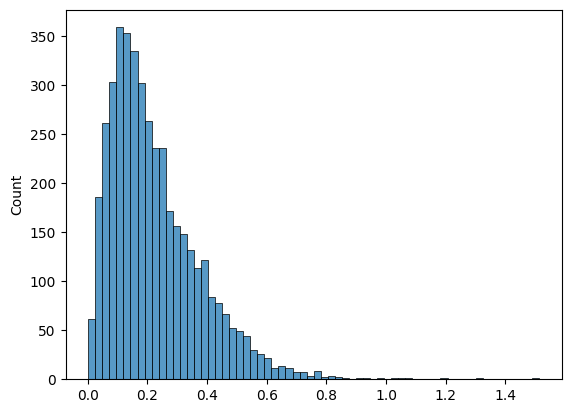

In [8]:
sns.histplot([edge['reprojected_err'] for edge in cam_marker_edges.values()])
# print the mean and std of the reprojected errors
print(np.mean([edge['reprojected_err'] for edge in cam_marker_edges.values()]),
      np.std([edge['reprojected_err'] for edge in cam_marker_edges.values()]))

# Optimization

In [ ]:
from src.vican.vican.geometry import SE3


# find tmax
t_final = max([int(k[1].split('_')[0]) for k in cam_marker_edges.keys()])

poses_over_time = dict()

for tmax in range(90, t_final, 50):
    
    edges = {k : v for k, v in cam_marker_edges.items() if int(k[1].split('_')[0]) < tmax}


    # Optimization - see extended paper
    root = str(min([int(e[1].split('_')[1]) for e in cam_marker_edges.keys()]))

    pose_est = bipartite_se3sync(edges,
                                 constraints=obj_pose_est,
                                 noise_model_r=lambda edge : 0.01 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**1.0,
                                 noise_model_t=lambda edge : 0.01 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**1.0,
                                 edge_filter=lambda edge : edge['reprojected_err'] < 1,
                                 maxiter=4,
                                 lsqr_solver="conjugate_gradient",
                                 dtype=np.float32)
    
    for cam_id, pose in pose_est.items():
        
        if "_" in cam_id:
            continue
        
        if str(tmax) not in poses_over_time:
            poses_over_time[str(tmax)] = dict()
        
        poses_over_time[str(tmax)][cam_id] = pose

In [9]:
pose_est = bipartite_se3sync(cam_marker_edges,
                            constraints=obj_pose_est,
                            noise_model_r=lambda edge : 0.01 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**1.0,
                            noise_model_t=lambda edge : 0.01 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**1.0,
                            edge_filter=lambda edge : edge['reprojected_err'] < 0.15,
                            maxiter=4,
                            lsqr_solver="conjugate_gradient",
                            dtype=np.float32)

Received graph with 2487 nodes 4269 edges
Applying constraints (0.159s).
Bipartite graph: 4 cameras, 492 timesteps, 941 edges.
Building 4x492 adjacency and 12x1476 SO(3) sparse matrices (0.015s).
Building power graph (0.004s).


Optimizing:   0%|                                                                            | 0/4 [00:00<?, ?…

Building sparse 4839x1488 incidence matrix (0.375s).
Solving sparse linear system (0.008s).
Done!


# Cameras D Plot

In [25]:
def plot_frame(ax, H, label):
    origin = H[:3, 3]
    x_axis = H[:3, 0]
    y_axis = H[:3, 1]
    z_axis = H[:3, 2]

    ax.quiver(*origin, *x_axis, color='r', length=0.05, normalize=True)
    ax.quiver(*origin, *y_axis, color='g', length=0.05, normalize=True)
    ax.quiver(*origin, *z_axis, color='b', length=0.05, normalize=True)
    ax.text(*origin, label, fontsize=12, color='k')

In [14]:
for time_step, cams_time in poses_over_time.items():
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.view_init(elev=0, azim=45, roll=0)

    for cam_id, pose in cams_time.items():
        plot_frame(ax, pose._pose, cam_id)
        
    #ax.set_xlim(-1, 1)
    #ax.set_ylim(-1, 1) 
    #ax.set_zlim(-1, 1)
    ax.set_aspect('equal')
    
    plt.show()
    
    plt.pause(0.1)

NameError: name 'poses_over_time' is not defined

NameError: name 'obj_pose_est' is not defined

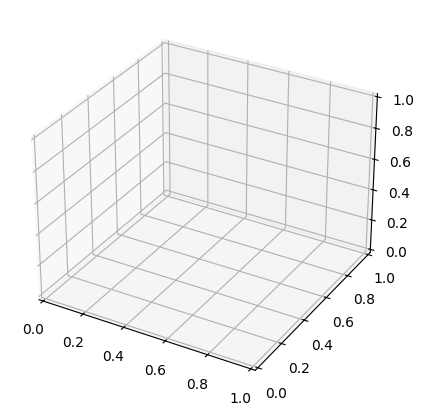

In [9]:
%matplotlib inline

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')

for cam_id, pose in obj_pose_est.items():
    if "_" in cam_id:
        continue
    
    #pose_est[cam_id] = pose_est[cam_id].inv() @ pose_est[wrl_idx]
    plot_frame(ax, obj_pose_est[cam_id]._pose , cam_id) # TODO: make a getter for the A matrix

# aspect ratio of the plot to be equal
ax.set_aspect('equal')

ax.view_init(elev=30, azim=45, roll=0)
#make the plot interactive
plt.show()


In [32]:
import json

obj_pose_est

json.dump(obj_pose_est, open(os.path.join(OBJ_DATASET_PATH, 'cube_calib_pose.json'), 'w'))

AttributeError: 'dict' object has no attribute '_pose'

In [13]:
from src.vican.vican.geometry import SE3, rotz
from src.vican.vican.plot import plot_cams_3D

for cam_id, cam in dataset.cams.items():
    
    cam.extrinsics = pose_est[cam_id] #@ SE3(R=rotz(np.pi), t=np.zeros((3,1)))
    # draw axis of frames of each camera

#dataset.cams{"4",SE3(R=np.eye)}

plot_cams_3D(dataset.cams.values())    

Saving to output.html


In [ ]:
import open3d as o3d

# Load the PCD file
pc0 = o3d.io.read_point_cloud("dataset/pointcloud0.pcd")
pc1 = o3d.io.read_point_cloud("dataset/pointcloud1.pcd")
pc2 = o3d.io.read_point_cloud("dataset/pointcloud2.pcd")

triad = o3d.open3d.geometry.TriangleMesh.create_coordinate_frame()

# transform point clouds to world frame
pc0.transform(pose_est['0'].pose())
pc1.transform(pose_est['1'].pose())
pc2.transform(pose_est['2'].pose())

#merge all 3 point clouds and write them to a file
pc = pc0 + pc1 + pc2
o3d.io.write_point_cloud("dataset/pointcloud_merged.pcd", pc)

# Visualize the point cloud
o3d.visualization.draw_geometries([pc2,pc0, triad])

In [14]:
position_list = []
for cam_id, pose in pose_est.items():
    if "_" in cam_id:
        continue
    position_list.append(pose_est[cam_id].t())
    print(np.linalg.det(pose_est[cam_id].R()))


print(position_list)


print(np.linalg.norm(position_list[0]- position_list[1]))
print(np.linalg.norm(position_list[1]- position_list[2]))
print(np.linalg.norm(position_list[2]- position_list[0]))

#print(cam_id)
#print(pose)
    

1.0000001
1.0000001
1.0
1.0
[array([ 1.55704908, -1.26127961, -1.23892176]), array([-0.01423371, -0.58185617,  1.97994477]), array([ 1.05878323, -1.01358497,  1.89681707]), array([ 0.47473095,  0.38509994, -1.81093406])]
3.645771181371627
1.1595970535844438
3.1847259668440766


In [18]:
import json
json_data = {}
for cam_id, pose in pose_est.items():    
    #check if cam_id is a valid camera index
    if "_" in cam_id:
        continue
    json_data[int(cam_id)] = {'R': pose_est[cam_id].R().tolist(), 't': pose_est[cam_id].t().tolist()}
    
with open("pose_est.json", 'w') as f:
    json.dump(json_data, f, indent=4)

print("done")

done


In [19]:
# get an array of 4 points in image frame and return the middle point
def get_middle_point(points):
    points = np.array(points)
    return np.mean(points, axis=0)


In [20]:
cam_marker_edges

#dict with all marker_id and camera_id
data = {}



for (camera, time_marker) in cam_marker_edges:
    #print(cam_marker_edges[(camera, time_marker)])
    time, marker = time_marker.split("_")
    
    # make every field in dictionary be a list and keep appending
    if (marker, camera) not in data:
        data[marker, camera] = []

    data[marker, camera].append( get_middle_point(cam_marker_edges[(camera, time_marker)]['corners']).tolist() )    

lst_mrk_ids = [int(int_id) for int_id in MARKER_IDS]
# create a subplot for every dictionary entry
fig, axs = plt.subplots(len(dataset.cams),len(MARKER_IDS),  figsize=(50, 15))

for i, (marker, camera) in enumerate(data):
    ax = axs[int(camera) , int(marker)- min(lst_mrk_ids)]
    new_data = np.array(data[marker, camera])
    ax.hist2d(new_data[:,0], new_data[:,1], bins=50,
             range=np.array([(0, dataset.cams["0"].resolution_x), (0, dataset.cams["0"].resolution_y)]))
    ax.set_title(f"Camera {camera}, Marker {marker}")

NameError: name 'MARKER_IDS' is not defined

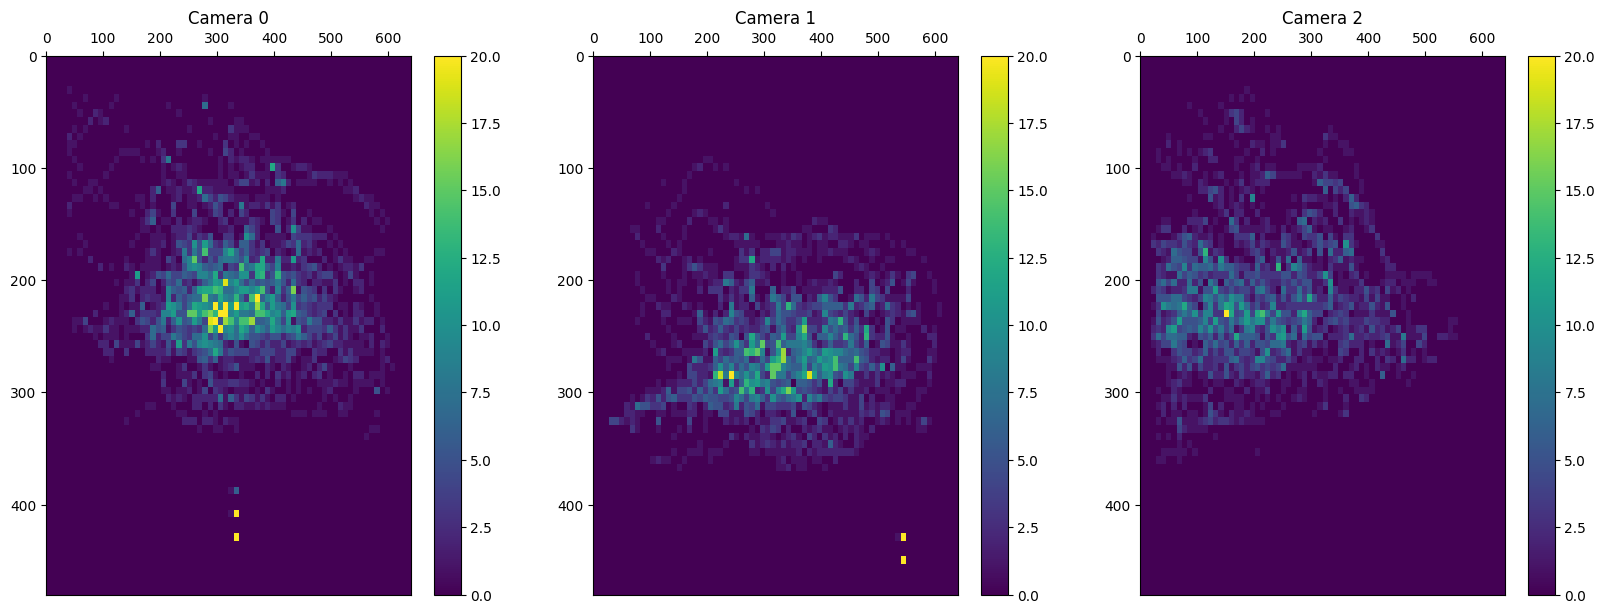

In [ ]:
dict_merge_mrks = {}
for field in data.keys():
    
    if field[1] not in dict_merge_mrks:
        dict_merge_mrks[field[1]] = []
        
    dict_merge_mrks[field[1]].append(data[field])


dict_merge_mrks.keys()

fig, axs = plt.subplots(1, len(dataset.cams),  figsize=(20,7))

for i, camera in enumerate(dict_merge_mrks):
    ax = axs[int(camera)]
    new_data = np.concatenate(dict_merge_mrks[camera], axis=0)
    h = ax.hist2d(new_data[:,0], new_data[:,1], bins=70,
                 range=np.array([(0, dataset.cams["0"].resolution_x), (0, dataset.cams["0"].resolution_y)]),
                 vmin=0, vmax=20)  
    a = plt.colorbar(h[3], ax=ax)
    #a.set_ticks([-1, 0, 1])

        
    ax.set_title(f"Camera {camera}")
    ax.xaxis.set_ticks_position('top')
    ax.invert_yaxis()



    